# A simple example for logistic regression
This notebook calculates a logistic regression using TensorFlow. It's basically meant to show the principles of TensorFlow.

## Datset

We investigate the data set of the challenger flight with broken O-rings (Y=1) vs start temperature.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
import tempfile
data = np.asarray(pd.read_csv('../data/challenger.txt', sep=','), dtype='float32')
plt.plot(data[:,0], data[:,1], 'o')
plt.axis([40, 85, -0.1, 1.2])
plt.xlabel('Temperature [F]')
plt.ylabel('Broken O-rings')

FileNotFoundError: File b'../data/challenger.txt' does not exist

In [2]:
y_values = data[:,1]

## Mathematical Notes
We are considering the likelihood $p(y_i=1|x_i)$ for the class $y_i=1$ given the $i-$th data point $x_i$ ($x_i$ could be a vector). This is given by:
$
p(y_i=1 | x_i) = \frac{e^{(b + W' x_i)}}{1 + e^{(b + W' x_i)}} = [1 + e^{-(b + W' x_i)}]^{-1}
$

If we have more than one data point, which we usually do, we have to apply the equation above to each of the N data points. In this case we can used a vectorized version with $x=(x_1,x_2,\ldots,x_N)$ and $y=(y_1,y_2,\ldots,y_N$)

### Numpy code
This numpy code, shows the calculation for one value using numpy (like a single forward pass)

In [3]:
# Data
N = len(data)
x = data[:,0]
y = data[:,1]
# Initial Value for the weights
w = -0.20
b = 20.0
# Log-Likelihood 
p_1 = 1 / (1 + np.exp(-x*w - b))
like = y * np.log(p_1) + (1-y) * np.log(1-p_1)
print(-np.mean(like))
print(np.round(p_1,3))

3.88292
[ 0.99900001  0.99800003  0.99800003  0.99800003  0.99900001  0.99599999
  0.99599999  0.99800003  1.          0.99900001  0.99800003  0.98799998
  0.99900001  1.          0.99900001  0.99299997  0.99800003  0.97799999
  0.99199998  0.98500001  0.99299997  0.99199998  1.        ]


## Better values from intuition

0.909443
[ 0.26899999  0.007       0.018       0.047       0.119       0.001       0.
  0.007       1.          0.88099998  0.007       0.          0.119       1.
  0.119       0.          0.007       0.          0.          0.          0.
  0.          0.99900001]


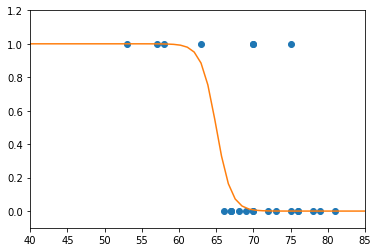

In [4]:
w_val = -1
b_val = 65
plt.plot(data[:,0], data[:,1], 'o')
plt.axis([40, 85, -0.1, 1.2])
x_pred = np.linspace(40,85)
x_pred = np.resize(x_pred,[len(x_pred),1])
y_pred = 1 / (1 + np.exp(-x_pred*w_val - b_val))
plt.plot(x_pred, y_pred)

p_1 = 1 / (1 + np.exp(-x*w_val - b_val))
like = y * np.log(p_1) + (1-y) * np.log(1-p_1)
print(-np.mean(like))
print(np.round(p_1,3))

### Tensorflow Code (forward pass)

In [5]:
import tensorflow as tf
tf.reset_default_graph() #Just to be sure to start with an empty graph

x = tf.placeholder('float32', [N], name='x_data')
y = tf.placeholder('float32', [N], name='y_data')
# Initial weights with initial values
w = tf.Variable(-1.0, name = 'w') 
b = tf.Variable(65.0, name = 'b')

init_op = tf.global_variables_initializer() 
p_1 = 1 / (1 + tf.exp(-x*w - b))
like = y * tf.log(p_1) + (1-y) * tf.log(1-p_1)
loss = -tf.reduce_mean(like) #<----- All up to now is a symbolic definition of a graph
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    loss_, p_1_val = sess.run(fetches = (loss, p_1), feed_dict={x:data[:,0], y:data[:,1]})
    print(loss_)
    print(p_1_val)

0.909443
[  2.68941432e-01   6.69285096e-03   1.79862101e-02   4.74258736e-02
   1.19202919e-01   9.11051175e-04   3.35350138e-04   6.69285096e-03
   9.99664664e-01   8.80797029e-01   6.69285096e-03   2.26032444e-06
   1.19202919e-01   9.99993801e-01   1.19202919e-01   4.53978719e-05
   6.69285096e-03   1.12535155e-07   1.67014223e-05   8.31528041e-07
   4.53978719e-05   1.67014223e-05   9.99089003e-01]


### Better values with gradient descent


In [6]:
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
#train_op = tf.train.AdagradOptimizer(0.1).minimize(loss)
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    for i in range(1000):
        loss_, _, w_val, b_val = sess.run(fetches=(loss, train_op, w, b), feed_dict={x:data[:,0], y:data[:,1]})
        if (i % 100 == 0):
            print("i={} loss={}".format(i,loss_))
print ("loss {} w {} b {}".format(loss_, w_val, b_val))

i=0 loss=0.9094434976577759
i=100 loss=0.7655227780342102
i=200 loss=0.7655167579650879
i=300 loss=0.7655097246170044
i=400 loss=0.7655035257339478
i=500 loss=0.7654967904090881
i=600 loss=0.7654904723167419
i=700 loss=0.765484094619751
i=800 loss=0.7654770612716675
i=900 loss=0.7654702663421631
loss 0.7654646039009094 w -0.9664034843444824 b 64.99285125732422


### Storing of the graph

In [7]:
with tf.Session() as sess:
    sess.run(init_op)
    writer = tf.summary.FileWriter("/tmp/Challenger", sess.graph) #<--- Where to store

### Performance can be visualized in Tensorboard

The performance can be visualized in Tensorboard. 
```
    tensorboard --logdir /tmp/ --port 8081
```
and open a browser at
http://localhost:8081